In [1]:
import pandas as pd
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

In [4]:
data = pd.read_csv(r"creditcard.csv")

In [5]:
y = data["Class"].values
x = data.drop(["Class"], axis=1)

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
y_scale = y.astype('bool')

In [12]:
## input layer ]

input_layer = Input(shape=(x.shape[1],))

## encoding part
encoded = Dense(100, activation='relu', activity_regularizer=regularizers.l1(1e-7))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='sigmoid')(encoded)
decoded = Dense(100, activation='sigmoid')(decoded)

## output layer
output_layer = Dense(x.shape[1], activation='sigmoid')(decoded)


In [13]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_scale, y_scale, test_size=0.2, random_state=2021)

In [9]:
x_norm_train = x_train[~y_train]
x_norm_test = x_test[~y_test]
x_fraud_train = x_train[y_train]
x_fraud_test = x_test[y_test]

In [10]:
print("Length of normal train",len(x_norm_train))
print("Length of normal test",len(x_norm_test))
print("Length of fraud train",len(x_fraud_train))
print("Length of fraud test",len(x_fraud_test))

Length of normal train 227456
Length of normal test 56859
Length of fraud train 389
Length of fraud test 103


In [11]:
H = autoencoder.fit(x_norm_train,x_norm_train,epochs=20, batch_size=100,shuffle=True, validation_data=(x_test,x_test))

Epoch 1/20
2275/2275 [==============================] - 8s 3ms/step - loss: 0.0654 - val_loss: 0.0563
Epoch 2/20
2275/2275 [==============================] - 9s 4ms/step - loss: 0.0478 - val_loss: 0.0402
Epoch 3/20
2275/2275 [==============================] - 9s 4ms/step - loss: 0.0340 - val_loss: 0.0287
Epoch 4/20
2275/2275 [==============================] - 8s 4ms/step - loss: 0.0245 - val_loss: 0.0210
Epoch 5/20
2275/2275 [==============================] - 8s 4ms/step - loss: 0.0182 - val_loss: 0.0159
Epoch 6/20
2275/2275 [==============================] - 8s 4ms/step - loss: 0.0140 - val_loss: 0.0124
Epoch 7/20
2275/2275 [==============================] - 8s 4ms/step - loss: 0.0110 - val_loss: 0.0099
Epoch 8/20
2275/2275 [==============================] - 10s 4ms/step - loss: 0.0089 - val_loss: 0.0082
Epoch 9/20
2275/2275 [==============================] - 9s 4ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 10/20
2275/2275 [==============================] - 8s 4ms/step - loss: 0.00

Text(0, 0.5, 'loss')

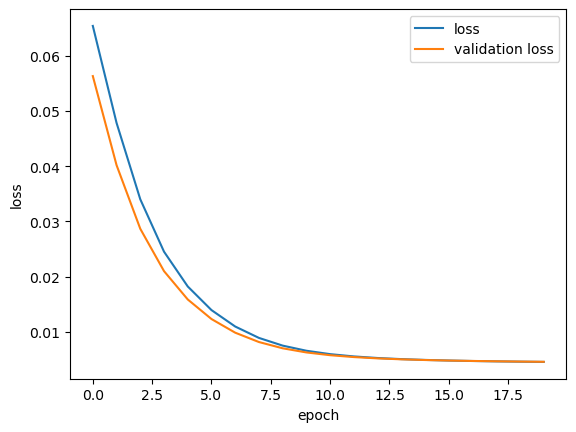

In [14]:
plt.plot(H.history['loss'], label='loss')
plt.plot(H.history['val_loss'], label='validation loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

In [15]:
test_pred = autoencoder.predict(x_test)
# Calculate mean along the columns
mse = np.mean(np.power(test_pred-x_test, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error':mse,'True_labels':y_test})

1781/1781 [==============================] - 3s 2ms/step


In [16]:
error_df

,Reconstruction_error,True_labels
0,0.080562,False
1,0.089394,False
2,0.079366,False
3,0.097928,False
4,0.079725,False
...,...,...
56957,0.086390,False
56958,0.090233,False
56959,0.088353,False
56960,0.077208,False


In [17]:
threshold = 0
groups = error_df.groupby('True_labels')

Text(0.5, 0, 'Data point index')

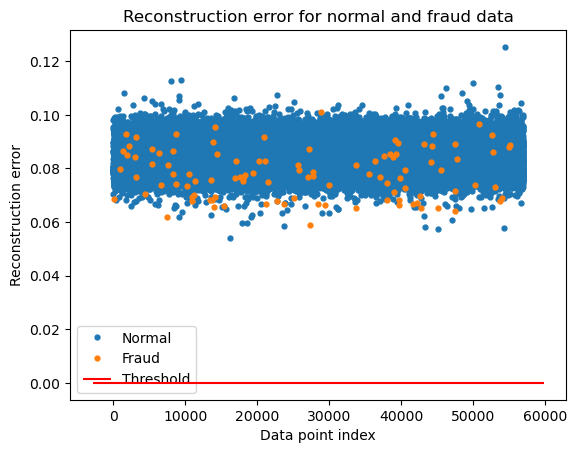

In [18]:
fig, ax = plt.subplots()
for labels, group in groups:
    plt.plot(group.index, group['Reconstruction_error'], marker='o',  ms=3.5, linestyle='', label='Fraud' if labels==1 else 'Normal')
plt.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
plt.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")

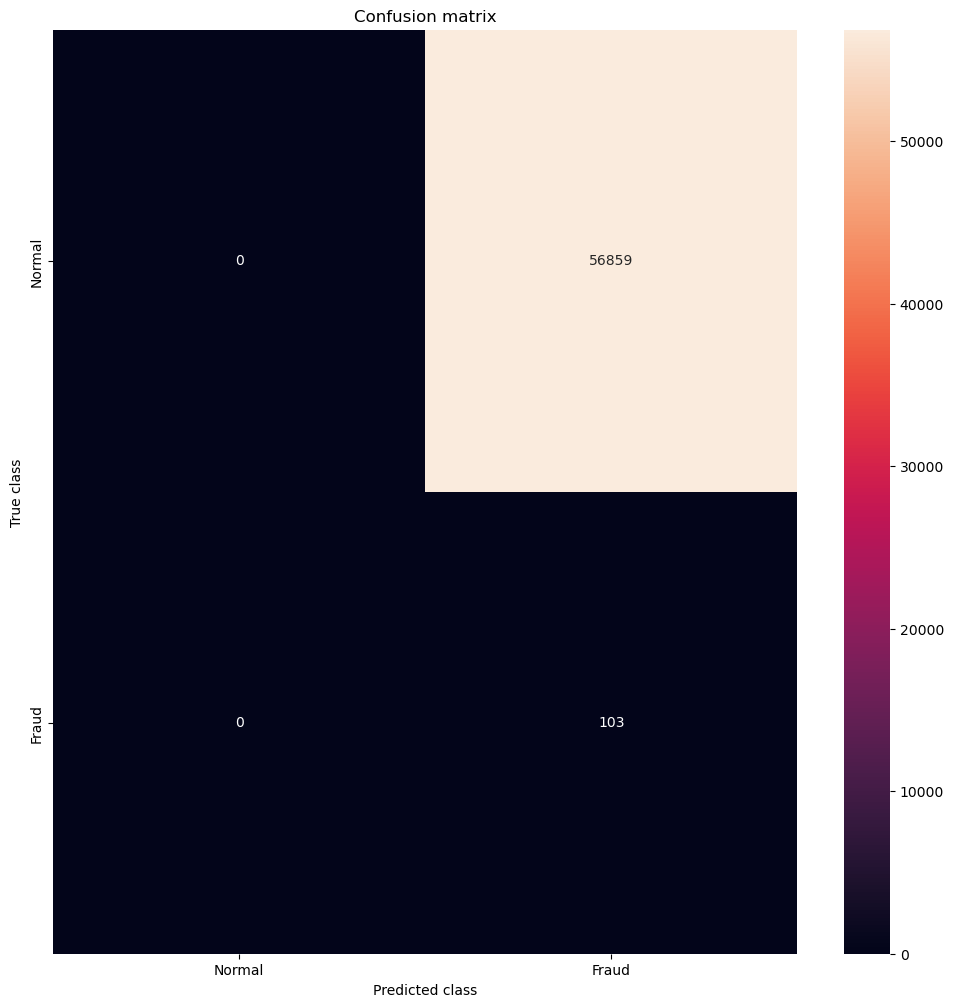

In [19]:
from sklearn.metrics import confusion_matrix

threshold_fixed = 0.0001
y_pred = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_labels, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=['Normal','Fraud'], yticklabels=['Normal','Fraud'], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()